<a href="https://colab.research.google.com/github/jglaser/hoomd_boltzmann/blob/master/hard_disk_boltzmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install git+https://github.com/jglaser/paper_boltzmann_generators.git@tf2#subdirectory=software

  Cloning https://github.com/jglaser/paper_boltzmann_generators.git (to revision tf2) to /tmp/pip-req-build-voilan_c
  Running command git clone -q https://github.com/jglaser/paper_boltzmann_generators.git /tmp/pip-req-build-voilan_c
  Running command git checkout -b tf2 --track origin/tf2
  Switched to a new branch 'tf2'
  Branch 'tf2' set up to track remote branch 'tf2' from 'origin'.
  Created wheel for deep-boltzmann: filename=deep_boltzmann-0.1-cp37-none-any.whl size=40082 sha256=13ae33123c1f841e0a89a7172841e75179a359838c5ba5b5d7f106e3afbdc94c
  Stored in directory: /tmp/pip-ephem-wheel-cache-3yf_002h/wheels/42/9f/f7/e2dcd8deb7caf454aae09d183c79d4112768020758493c87de
Successfully built deep-boltzmann


In [2]:
import deep_boltzmann

In [3]:
import matplotlib.pyplot as plt
def plot_config(pts,L=1):
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    circles = [plt.Circle(p,.5) for p in pts]
    for c in circles:
        ax.add_patch(c)
    ax.set_xlim(-L/2,L/2)
    ax.set_ylim(-L/2,L/2)

### Invertible network for hard particles

In [4]:
# Maximum likelihood in z
import tensorflow as tf
def loss_z(inv_net):
    return -inv_net.log_likelihood_z_normal()

In [460]:
import tensorflow as tf
def loss_x(inv_net):
    x = inv_net.output_x
    f = inv_net.overlap_model.smooth_overlap_tf(x)
    return tf.where(f>tf.zeros_like(f),tf.math.log(f)-inv_net.log_det_Jzx[:,0],0.0)
    #return f*tf.math.exp(-inv_net.log_det_Jzx[:,0])
   # return f-inv_net.log_det_Jzx[:,0]#-0.5*tf.reduce_sum(inv_net.input_z**2,axis=-1)
    

In [461]:

import tensorflow.keras as keras
import tensorflow as tf
from deep_boltzmann.networks.invertible import InvNet

class OverlapInvNet(InvNet):

    def __init__(self, overlap_model, layers):
        """ Invertible net where we have an overlap function (==0 or 1) that defines p(x)
            and the prior is the uniform on the interval [a,b)"""
        self.overlap_model = overlap_model
        super().__init__(overlap_model.dim, layers, prior='normal')
        
        self.Tzx.add_loss(loss_x(self))
        self.Txz.add_loss(loss_z(self))
        
    @classmethod
    def load(cls, filename, energy_model):
        """ Loads parameters into model. Careful: this clears the whole TF session!!
        """
        from deep_boltzmann.util import load_obj
        keras.backend.clear_session()
        D = load_obj(filename)
        layerdicts = D['layers']
        layers = [eval(d['type']).from_dict(d) for d in layerdicts]
        return EnergyInvNet(energy_model, layers, prior=prior)

    def weight(self):
        """ Computes the reweighting factor
        """
        z = self.input_z
        x = self.output_x
        # compute overlap property
        f = self.overlap_model.overlap_tf(x)
        weight = tf.math.exp(self.log_det_Jzx[:, 0])
        return weight

    def sample(self, nsample=100000):
        """ Samples from prior distribution in z and produces generated x configurations

        Parameters:
        -----------
        temperature : float
            Relative temperature. Equal to the variance of the isotropic Gaussian sampled in z-space.
        nsample : int
            Number of samples

        Returns:
        --------
        sample_z : array
            Samples in z-space
        sample_x : array
            Samples in x-space
        weight_z:
            Weight of z samples
        overlap_x : array
            Overlap property of x samples
        w : array
            Weight of samples

        """
        sample_z, energy_z = self.sample_z(nsample=nsample, return_energy=True)
        sample_x, Jzx = self.transform_zxJ(sample_z)
        overlap_x = self.overlap_model.overlap(sample_x)
        w = np.exp(Jzx)

        return sample_z, sample_x, np.exp(-energy_z), overlap_x, w

    
    def train_z(self, x, xval=None, optimizer=None, lr=0.001, epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
                
        self.Txz.compile(optimizer)

        if xval is not None:
            validation_data = (xval, np.zeros_like(xval))
        else:
            validation_data = None

        hist = self.Txz.fit(x=x, validation_data=validation_data,
                            batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist
    
    def train_x(self, optimizer=None, lr=0.001, batches=1,epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
                
        self.Tzx.compile(optimizer)

        x = self.sample_z(nsample=batches*batch_size, return_energy=False)
        hist = self.Tzx.fit(x=x,batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist

    def train_both(self, x, xval=None, optimizer=None, lr=0.001, epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
       
        inputs = []
        outputs = []
        losses = []
        losses.append(loss_z(self))
        losses.append(loss_x(self))
        inputs.append(self.input_x)
        inputs.append(self.input_z)
        outputs.append(self.output_z)
        outputs.append(self.output_x)

        self.model = keras.models.Model(inputs=inputs, outputs=outputs)
        l = losses[0]+losses[1]
        self.model.add_loss(l)
        self.model.compile(optimizer=optimizer)
        
        if xval is not None:
            validation_data = (xval, np.zeros_like(xval))
        else:
            validation_data = None

        w = self.sample_z(nsample=x.shape[0], return_energy=False)
        hist = self.model.fit(x=[x,w], validation_data=validation_data,
                            batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist

In [588]:
class Limit(object):
    def __init__(self, dim, L=1):
        self.L = L
        self.dim = dim
    
        self.tanh = tf.keras.layers.Activation('tanh')
        self.scale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=self.L/2)
        self.inv_scale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=2/self.L)
        self.atanh = tf.keras.layers.Activation(lambda x: tf.atanh(x))
        
    def connect_xz(self, x):
        def lambda_Jxz(x):
            J = -tf.math.log(1-(2*x/self.L)**2)
            return tf.reduce_sum(J,axis=-1)[0] * tf.ones((tf.shape(x)[0], 1))
        self.log_det_xz = keras.layers.Lambda(lambda_Jxz)(x)
        z = self.atanh(self.inv_scale(x))
        return z

    def connect_zx(self, z):
        def lambda_Jzx(z):
            J = -tf.math.log(tf.cosh(z)**2)
            return tf.reduce_sum(J,axis=-1)[0] * tf.ones((tf.shape(z)[0], 1))
        self.log_det_zx = keras.layers.Lambda(lambda_Jzx)(z)
        x = self.scale(self.tanh(z))
        return x

    @property
    def log_det_Jxz(self):
        """ Log of |det(dz/dx)| for the current batch. Format is batchsize x 1 or a number """
        return self.log_det_xz

    @property
    def log_det_Jzx(self):
        """ Log of |det(dx/dz)| for the current batch. Format is batchsize x 1 or a number """
        return self.log_det_zx


In [589]:
from deep_boltzmann.networks.invertible import split_merge_indices, SplitChannels, MergeChannels, \
                                               RealNVP, NICER, InvNet, nonlinear_transform, Scaling

def invnet(dim, layer_types, overlap_model=None, channels=None, L=1.0,
           nl_layers=2, nl_hidden=100, nl_activation='relu',
           nl_activation_t='relu',scale=None, prior='normal'):
    """
    layer_types : str
        String describing the sequence of layers. Usage:
            N NICER layer
            R RealNVP layerl
            S Scaling layer
        Splitting and merging layers will be added automatically
    overlap_model : Overlap model class
        Class with overlap_tf() and dim
    channels : array or None
        Assignment of dimensions to channels (0/1 array of length ndim)
    nl_layers : int
        Number of hidden layers in the nonlinear transformations
    nl_hidden : int
        Number of hidden units in each nonlinear layer
    nl_activation : str
        Activation functions used in the nonlinear layers
    scale : None or float
        If a scaling layer is used, fix the scale to this number. If None, scaling layers are trainable
    """
    # fix channels
    channels, indices_split, indices_merge = split_merge_indices(dim, nchannels=2, channels=channels)

    # augment layer types with split and merge layers
    split = False
    tmp = ''
    for ltype in layer_types:
        if (ltype == 'S' or ltype == 'L') and split:
            tmp += '>'
            split = False
        if (ltype == 'N' or ltype == 'R') and not split:
            tmp += '<'
            split = True
        tmp += ltype
    if split:
        tmp += '>'
    layer_types = tmp
    print(layer_types)

    # prepare layers
    layers = []

    #reg = tf.keras.regularizers.l2(.1) #?
    reg = None
    for ltype in layer_types:
        if ltype == '<':
            # split into two x channels
            layers.append(SplitChannels(dim, nchannels=2, channels=channels))
        if ltype == '>':
            # merge into one z channel
            layers.append(MergeChannels(dim, nchannels=2, channels=channels))
        if ltype == 'N':
            M1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation)
            M2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation)
            layers.append(NICER([M1, M2]))
        elif ltype == 'R':
            S1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, init_outputs=0,
                                     activity_regularizer=reg)
            T1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation_t)
            S2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, init_outputs=0,
                                     activity_regularizer=reg)
            T2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation_t)
            layers.append(RealNVP([S1, T1, S2, T2]))
        elif ltype == 'L':
            layers.append(Limit(dim, L=L))
        elif ltype == 'S':
            # scaling layer
            if scale is None:
                scaling_factors = None
            else:
                scaling_factors = scale * np.ones((1, dim))
            layers.append(Scaling(dim, scaling_factors=scaling_factors, trainable=(scale is None)))

    if overlap_model is None:
        inv_net = InvNet(dim, layers, prior='normal')
    else:
        inv_net = OverlapInvNet(overlap_model, layers)
    
    inv_net.reg = reg
    return inv_net

### Hard disk overlap

In [610]:
import numpy as np

def ensure_traj(X):
    if np.ndim(X) == 2:
        return X
    if np.ndim(X) == 1:
        return np.array([X])
    raise ValueError('Incompatible array with shape: ', np.shape(X))

    
def dist2_min_image(crd1, crd2, L, dim=2):
    """ Returns the distance matrix or matrices between particles, with periodic boundary conditions

    Parameters
    ----------
    crd1 : array or matrix
        first coordinate set
    crd2 : array or matrix
        second coordinate set
    L: length of simulation box
    dim : int
        dimension of particle system. If d=2, coordinate vectors are [x1, y1, x2, y2, ...]

    """
    crd1 = ensure_traj(crd1)
    crd2 = ensure_traj(crd2)
    n = int(np.shape(crd1)[1]/dim)

    crd1_components = [np.tile(np.expand_dims(crd1[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    crd2_components = [np.tile(np.expand_dims(crd2[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    
    dr_components = np.array([(crd1_components[i] - np.transpose(crd2_components[i], axes=(0, 2, 1))) for i in range(dim)])
    
    # minimum image
    D2_components = dr_components - L*((dr_components+0.5*L)//L)
    D2_components = D2_components**2
    D2 = np.sum(D2_components, axis=0)
    return D2

class HardDisks(object):
    def __init__(self,N, L,sigma,eps=1):
        """ N: number of particles
            L: Box length
            sigma: Particle size"""
        self.N = N
        self.dim = 2*self.N # dim = 2
        self.L = L
        self.sigma = sigma
        self.mask_matrix = np.ones((self.N, self.N), dtype=np.float32)
        for i in range(self.N):
            self.mask_matrix[i, i] = 0.0
        self.eps=eps

    def wrap(self, x):
        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]        
        xcomp -= ((xcomp+0.5*self.L)//self.L)*self.L
        ycomp -= ((ycomp+0.5*self.L)//self.L)*self.L
        out = np.zeros(shape=x.shape)
        out[:,0::2] = xcomp
        out[:,1::2] = ycomp
        return out
    
    def overlap(self, x):
        # all pairwise distances
        batchsize = np.shape(x)[0]
        D2 = dist2_min_image(x, x, self.L)
        mmatrix = np.tile(np.expand_dims(self.mask_matrix, 0), (batchsize, 1, 1))
        
        # overlap
        f = np.max(mmatrix*np.where(D2<self.sigma*self.sigma,1.0,0.0), axis=(1, 2))
        return f
    

    @tf.custom_gradient
    def tf_min_image(self,Dx):
        res = Dx-tf.math.floordiv(Dx+0.5*self.L,self.L)*self.L
        return res, lambda upstream: upstream

    def overlap_tf(self, x):

        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        batchsize = tf.shape(x)[0]
        n = tf.shape(xcomp)[1]
        Xcomp = tf.tile(tf.expand_dims(xcomp, 2), [1, 1, n])
        Ycomp = tf.tile(tf.expand_dims(ycomp, 2), [1, 1, n])
        Dx = Xcomp - tf.transpose(Xcomp, perm=[0, 2, 1])
        Dy = Ycomp - tf.transpose(Ycomp, perm=[0, 2, 1])

        # minimum image
        layer_min_image = tf.keras.layers.Lambda(lambda x: self.tf_min_image(x))
        Dx = layer_min_image(Dx) 
        Dy = layer_min_image(Dy) 
        D2 = Dx**2 + Dy**2

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])

        return tf.reduce_max(tf.where((D2<self.sigma*self.sigma),
                                      mmatrix*tf.ones_like(D2),tf.zeros_like(D2)),
                             axis=(1, 2))
    
    def smooth_overlap_tf(self, x):

        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        batchsize = tf.shape(x)[0]
        n = tf.shape(xcomp)[1]
        Xcomp = tf.tile(tf.expand_dims(xcomp, 2), [1, 1, n])
        Ycomp = tf.tile(tf.expand_dims(ycomp, 2), [1, 1, n])

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])

        # minimum image
        layer_min_image = tf.keras.layers.Lambda(lambda x: self.tf_min_image(x))
        Dx = Xcomp - tf.transpose(Xcomp, perm=[0, 2, 1])
        Dy = Ycomp - tf.transpose(Ycomp, perm=[0, 2, 1])
        Dx = layer_min_image(Dx) 
        Dy = layer_min_image(Dy) 
        D2 = Dx**2 + Dy**2

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])
        return tf.reduce_sum(self.eps*tf.nn.relu(mmatrix*(self.sigma-tf.math.sqrt(D2))), axis=(1, 2))

        # res = None
        # for i in range(-1,2):
        #     for j in range(-1,2):

        #       Dx = Xcomp - tf.transpose(Xcomp+i*self.L, perm=[0, 2, 1])
        #       Dy = Ycomp - tf.transpose(Ycomp+j*self.L, perm=[0, 2, 1])
        #       D2 = Dx**2 + Dy**2

        #       o = tf.reduce_sum(self.eps*tf.nn.relu(mmatrix*(self.sigma-tf.math.sqrt(D2))), axis=(1, 2))
        #       if res == None:
        #           res = o
        #       else:
        #           res += o
        # return res

### Create the model

In [611]:
phi = 0.3 # packing fraction
N = 64
sigma = 1
L = (N*(np.pi*0.25*sigma**2)/phi)**0.5

In [612]:
model = HardDisks(N=N,
                  L=L,
                  sigma=sigma,
                  eps=5)

In [613]:
batchsize = 4096

### Train with the linear combination of two loss functions

In [614]:
def act(x):
    return -tf.keras.layers.ReLU(max_value=10)(x)
    #return -tf.math.sigmoid(x)

In [615]:
# reset model
#bg = invnet(model.dim, 'RRRRRRRRL', overlap_model=model, nl_layers=4, nl_hidden=200, #100
bg = invnet(model.dim, 'LRRRRRRRR', overlap_model=model, nl_layers=4, nl_hidden=200, #100
#bg = invnet(model.dim, 'NNNNNNNNL', overlap_model=model, nl_layers=4, nl_hidden=200, #100
           nl_activation=act, nl_activation_t='relu',L=L)

L<RRRRRRRR>


In [616]:
#hist_bg = bg.train_z(x=Xtrain,epochs=3,lr=0.0001,batch_size=batchsize)

In [ ]:
hist_bg = bg.train_x(batches=250,epochs=10,lr=0.0001,batch_size=batchsize)

Epoch 1/10
250/250 [==============================] - 27s 82ms/step - loss: 125.2619
Epoch 2/10
250/250 [==============================] - 21s 82ms/step - loss: 111.8686
Epoch 3/10
 17/250 [=>............................] - ETA: 19s - loss: 104.4127

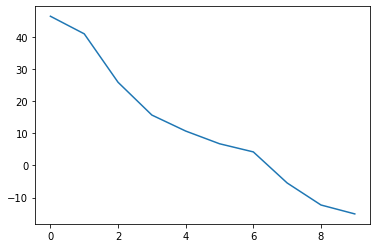

In [524]:
fig, ax = plt.subplots()
ax.plot(hist_bg.history['loss'])

In [525]:
print(tf.__version__)

2.4.1


In [526]:
_, sample_x, _, overlap_x, w = bg.sample(nsample=1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in exp


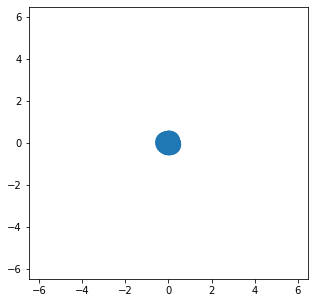

In [527]:
plot_config(model.wrap(bg.Tzx.predict(np.zeros_like(sample_x[0:1]))).reshape(-1,2),L=L)

In [528]:
L

12.944172750371328

In [529]:
sample_x[0]

array([-5.9621312e+05,  4.5271900e+06, -8.8889012e+05, -9.1978120e+06,
        3.8192072e+05, -4.5036297e+05,  4.7868703e+04, -3.4227212e+05,
       -1.0753031e+05, -7.0775312e+05,  2.9066362e+05,  6.9365450e+06,
        8.5700562e+04, -1.2515046e+06, -1.8518531e+06,  4.6762745e+06,
       -3.1481094e+05,  6.2445581e+05,  2.8050897e+05, -1.6621764e+06,
        4.1404341e+05, -1.4860311e+06, -3.7611597e+05,  5.3676505e+06,
        2.4402338e+05,  1.1474050e+06,  4.0984227e+04,  4.1796532e+07,
       -8.4973488e+05,  5.9118205e+06, -1.4411812e+07, -2.9186210e+06,
        1.4534797e+05, -1.4557078e+07, -3.4401296e+07,  2.0512098e+06,
        7.0447856e+05, -4.1076109e+05, -3.6203625e+05,  8.1095245e+06,
       -2.2606205e+05,  3.2904575e+06,  1.0304251e+06, -5.7489712e+05,
       -5.7271231e+05, -7.0054320e+06, -2.8019838e+05,  3.6621472e+06,
       -3.7629700e+06,  6.0639410e+06, -2.5583047e+05, -8.6446112e+05,
       -2.1674998e+05,  1.1266002e+07,  2.3702953e+05,  1.1297737e+07,
      

In [530]:
sample_x[0].min(), sample_x[0].max()

(-34401296.0, 41796532.0)

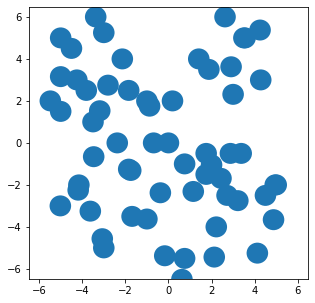

In [531]:
plot_config(model.wrap(sample_x)[0:1].reshape(-1,2),L=L)

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

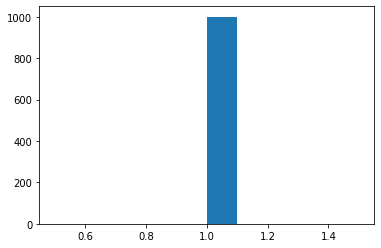

In [235]:
fig, ax = plt.subplots()
ax.hist(model.overlap(sample_x))

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: ignored

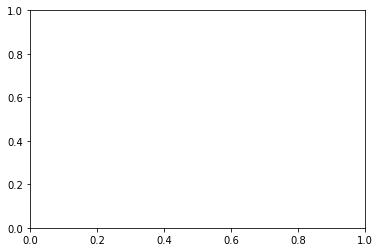

In [166]:
fig, ax = plt.subplots()
ax.hist(tf.keras.backend.eval(model.smooth_overlap_tf(sample_x)*w/tf.reduce_mean(w)),bins=20)
ax.set_yscale('log')

NameError: ignored

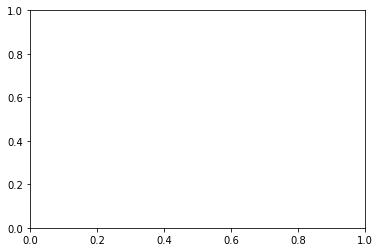

In [144]:
fig, ax = plt.subplots()
ax.hist(tf.keras.backend.eval(model.smooth_overlap_tf(Xtrain[0:1000])),bins=20)